## Description

This project consists of two parts. In the first part, I built, trained and tested a MLP network for a 2D synthetic dataset. In the second part, I developed an encoder-decoder  CNN architecture for image reconstruction and used the encoder part for further training a classifier. I used the MNIST dataset.

# PART 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification


In [2]:

moons = make_circles(1000, random_state=0,factor=0.5, noise=0.1)
circles = make_moons(1000, random_state=0, noise=0.1)

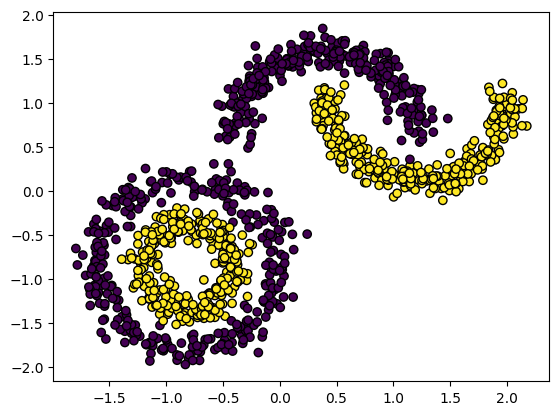

In [3]:
X, y = moons
X1,y1 = circles
X = np.vstack((X,X1+1.5))
y = np.hstack((y,y1))

# pre-proces data
X = StandardScaler().fit_transform(X)

# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
    )

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

# Plot the training points
ax = plt.axes()
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,  edgecolors="k")

In [4]:
import torch
import torch.nn as nn

class MLP(nn.Module):
  def __init__(self,input_size, hidden_layer_sizes, output_size=2):
    super(MLP, self).__init__()
    layer_sizes = [input_size] + hidden_layer_sizes + [output_size]

    self.model = nn.Sequential()
    for i in range(len(layer_sizes)-1):
      self.model.append(nn.Linear(layer_sizes[i],layer_sizes[i+1]))
      #Add ReLU as activation function except output layer
      if(i != len(layer_sizes)-2):
        self.model.append(nn.ReLU())
      #Add sigmoid as activation function for the output layer
      else:
        self.model.append(nn.Sigmoid())

  def forward(self, x):
    return self.model(x)


input_size = 2
hidden_layer_sizes = [16,8]
output_size = 1

mlp = MLP(input_size, hidden_layer_sizes, output_size)

In [5]:
import torch.optim as optim

loss_function = nn.BCELoss()

learning_rate = 0.01
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)


In [6]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 256

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_test_t = torch.from_numpy(X_test).to(torch.float32)
y_test_t = torch.from_numpy(y_test).to(torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

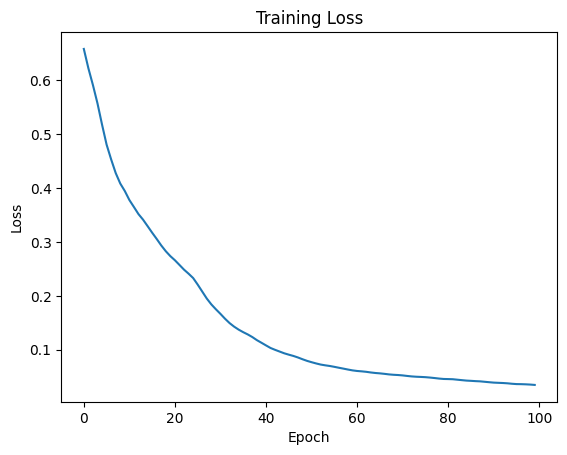

In [7]:
NUM_EPOCHS = 100

def train_model(model, train_dataloader, optimizer):
  losses = []

  #Iterate over the dataset several times (Determinedd by NUM_EPOCHS)
  for i in range(NUM_EPOCHS):
    for idx, (data, target) in enumerate(train_dataloader):
      optimizer.zero_grad()
      pred = model(data)
      pred = pred.squeeze()
      loss_value = loss_function(pred, target)
      loss_value.backward()
      optimizer.step()

    losses.append(loss_value.item())

  return losses

losses = train_model(mlp, train_dataloader, optimizer)

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


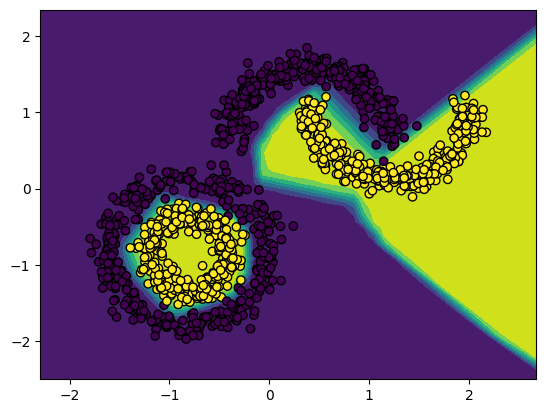

In [8]:
xs, ys = np.meshgrid(np.linspace(x_min, x_max), np.linspace(y_min, y_max))
gr_data = np.float32(np.vstack((xs.flatten(), ys.flatten())).transpose())
gr_out = mlp(torch.from_numpy(gr_data))
gr_out = gr_out.detach().numpy().reshape(xs.shape)

ax = plt.axes()
ax.contourf(xs,ys,gr_out, )
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,  edgecolors="k")

In [9]:
def evaluate_model(model, test_dataloader):
  model.eval()

  correct = 0
  total = 0

  with torch.no_grad():
    for data, target in test_dataloader:
      output = model(data)
      output = output.squeeze()

      predicted = (output > 0.5).float() #Set threshold to 0.5 for binary classification

      correct += (predicted == target).sum().item()
      total += target.size(0)

  accuracy = 100 * correct / total
  return accuracy

accuracy = evaluate_model(mlp, test_dataloader)
print(accuracy)

98.75


In [10]:
# split the training dataset into train and val sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

best_learning_rate = None
highest_val_accuracy = 0

learning_rates=[0.03, 0.01, 0.003, 0.001]

for lr in learning_rates:
  model = MLP(input_size, hidden_layer_sizes, output_size)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  losses = train_model(model, train_dataloader, optimizer)
  val_accuracy = evaluate_model(model, val_dataloader)

  if val_accuracy > highest_val_accuracy:
    best_learning_rate = lr
    highest_val_accuracy = val_accuracy

  test_accuracy = evaluate_model(model, test_dataloader)

  #print(f"lr:{lr}  final training loss:{losses[-1]}  validation accuracy:{val_accuracy}  test accuracy:{test_accuracy}")

Report your results by completing the table below.

| Learning rate (lr) | Final training loss | Validation set accuracy | Test set accuracy |
| ---                | ---                 | ---               | ---
| lr1= 0.03 | 0.006 | 97.5 | 98.0 |  
| lr2= 0.01 | 0.044 | 98.3 | 99.0 |
| lr3= 0.003 | 0.208 | 92.5 | 92.0 |
| lr4= 0.001 | 0.447 | 77.5 | 81.0 |



# PART 2 
In this part, I worked on developing an encoder-decoder (see figure below) CNN architecture for image reconstruction and used the encoder part for further training a classifier.

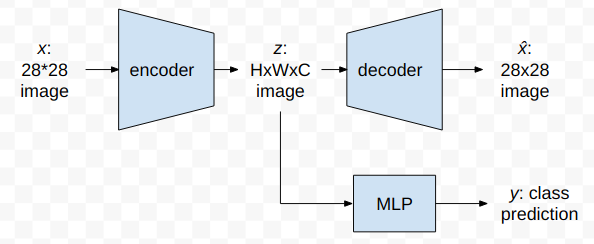

In [11]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Make sure you select "GPU" or "TPU" as the Hardware Accelarator, which is accesible from the "Rutime -> Change runtime type" menu.

In [13]:
# Download the dataset
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

In [15]:
# Define the data loaders
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset =  test_data ,
                                      batch_size = batch_size,
                                      shuffle = False)

In [16]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential()
        self.model.append(nn.Conv2d(in_channels=1,out_channels=32, kernel_size=3, stride=1, padding=2))
        self.model.append(nn.ReLU())
        self.model.append(nn.MaxPool2d(kernel_size=2))

        self.model.append(nn.Conv2d(in_channels=32,out_channels=128, kernel_size=3, stride=1, padding=2))
        self.model.append(nn.ReLU())

        self.model.append(nn.Conv2d(in_channels=128,out_channels=16, kernel_size=3, stride=1, padding=1))
        self.model.append(nn.ReLU())
        self.model.append(nn.MaxPool2d(kernel_size=2))

        self.model.append(nn.Conv2d(in_channels=16,out_channels=3, kernel_size=3, stride=1, padding=1))
        self.model.append(nn.ReLU())
        self.model.append(nn.MaxPool2d(kernel_size=2))

    def forward(self, x):
        return self.model(x)

In [17]:
encoder = Encoder().to(device)

x = torch.randn(20, 1, 28, 28).to(device)
y = encoder(x)
print(x.shape)
print(y.shape)

torch.Size([20, 1, 28, 28])
torch.Size([20, 3, 4, 4])


In [18]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.model = nn.Sequential()
    self.model.append(nn.ConvTranspose2d(in_channels=3, out_channels=16, kernel_size=3, stride=1))
    self.model.append(nn.ReLU())
    self.model.append(nn.ConvTranspose2d(in_channels=16, out_channels=128, kernel_size=3, stride=2))
    self.model.append(nn.ReLU())
    self.model.append(nn.ConvTranspose2d(in_channels=128, out_channels=32, kernel_size=3, stride=2))
    self.model.append(nn.ReLU())
    self.model.append(nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=1, padding=1))
    self.model.append(nn.Sigmoid())


  def forward(self, x):
    return self.model(x)

In [19]:
decoder = Decoder().to(device)

x = torch.randn(20, 3, 4, 4).to(device)
y = decoder(x)
print(x.shape)
print(y.shape)

torch.Size([20, 3, 4, 4])
torch.Size([20, 1, 28, 28])


I trained the encoder and decocer simultaneously to minimize the mean squared error (MSE), that is

$$L = \frac{1}{M}\sum_{i=1} (x_i - \hat{x}_i)^2 $$

where $M$ is the number of all examples in the training set.

In [20]:
loss_fun = nn.MSELoss()
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=1.e-3)

In [21]:
# Train the model

num_epochs = 5
loss_history = []
for epoch in range(num_epochs):
  for i ,(images,labels) in enumerate(train_loader):
    images = images.to(device)

    optimizer.zero_grad()
    latent = encoder(images)
    rec = decoder(latent)
    loss = loss_fun(rec, images)
    loss.backward()
    optimizer.step()

    if (i+1) % batch_size == 0:
      loss_history.append(loss.item())
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))

Epoch [1/5], Step [100/600], Loss: 0.0446
Epoch [1/5], Step [200/600], Loss: 0.0370
Epoch [1/5], Step [300/600], Loss: 0.0276
Epoch [1/5], Step [400/600], Loss: 0.0261
Epoch [1/5], Step [500/600], Loss: 0.0266
Epoch [1/5], Step [600/600], Loss: 0.0234
Epoch [2/5], Step [100/600], Loss: 0.0226
Epoch [2/5], Step [200/600], Loss: 0.0226
Epoch [2/5], Step [300/600], Loss: 0.0200
Epoch [2/5], Step [400/600], Loss: 0.0186
Epoch [2/5], Step [500/600], Loss: 0.0183
Epoch [2/5], Step [600/600], Loss: 0.0205
Epoch [3/5], Step [100/600], Loss: 0.0180
Epoch [3/5], Step [200/600], Loss: 0.0180
Epoch [3/5], Step [300/600], Loss: 0.0158
Epoch [3/5], Step [400/600], Loss: 0.0178
Epoch [3/5], Step [500/600], Loss: 0.0159
Epoch [3/5], Step [600/600], Loss: 0.0166
Epoch [4/5], Step [100/600], Loss: 0.0189
Epoch [4/5], Step [200/600], Loss: 0.0169
Epoch [4/5], Step [300/600], Loss: 0.0168
Epoch [4/5], Step [400/600], Loss: 0.0155
Epoch [4/5], Step [500/600], Loss: 0.0138
Epoch [4/5], Step [600/600], Loss:

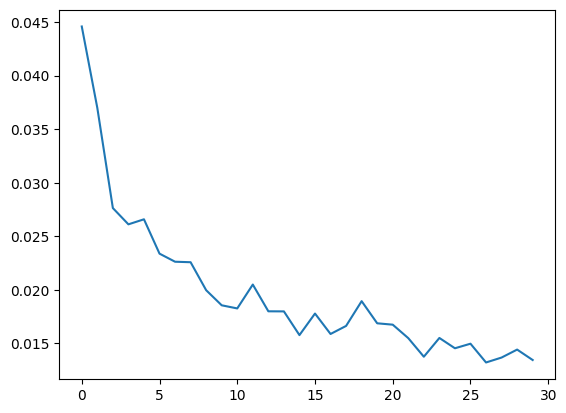

In [22]:
import matplotlib.pyplot as plt
plt.plot(loss_history)

Show an example $x$ and its correspoinding $\hat{x}$.

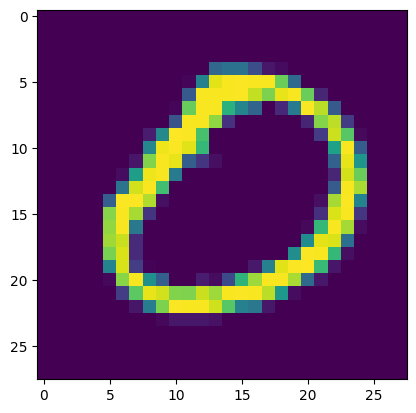

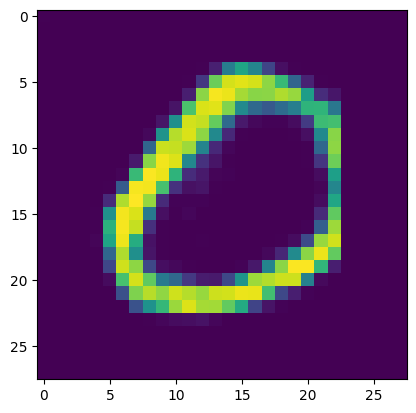

In [23]:
plt.imshow(images[0,0,].cpu().numpy())
plt.show()
plt.imshow(rec[0,0,].detach().cpu().numpy())
plt.show()

In [24]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.model = nn.Sequential()
    self.model.append(nn.Flatten())
    self.model.append(nn.Linear(48,128))
    self.model.append(nn.ReLU())
    self.model.append(nn.Linear(128,256))
    self.model.append(nn.ReLU())
    self.model.append(nn.Linear(256,10))


  def forward(self, x):
    return self.model(x)

mlp = MLP().to(device)

print(mlp)
x = torch.randn(20, 3, 4, 4).to(device)
y = mlp(x)
y.shape

MLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=48, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)


torch.Size([20, 10])

In [25]:
# Define the loss function and the optimizer
loss_fun = nn.CrossEntropyLoss()
params = mlp.parameters()
optimizer = torch.optim.Adam(params, lr=1.e-3)

Epoch [1/2], Step [100/600], Loss: 0.4741
Epoch [1/2], Step [200/600], Loss: 0.3772
Epoch [1/2], Step [300/600], Loss: 0.3607
Epoch [1/2], Step [400/600], Loss: 0.2031
Epoch [1/2], Step [500/600], Loss: 0.1991
Epoch [1/2], Step [600/600], Loss: 0.3116
Epoch [2/2], Step [100/600], Loss: 0.3176
Epoch [2/2], Step [200/600], Loss: 0.0730
Epoch [2/2], Step [300/600], Loss: 0.3656
Epoch [2/2], Step [400/600], Loss: 0.2208
Epoch [2/2], Step [500/600], Loss: 0.1392
Epoch [2/2], Step [600/600], Loss: 0.1431


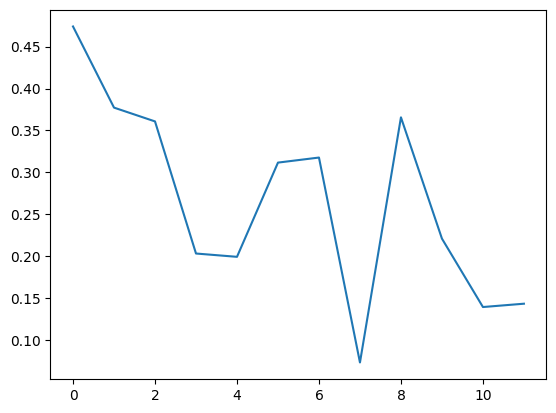

In [26]:
# Train the model
num_epochs = 2
loss_history = []
for epoch in range(num_epochs):
  for i ,(images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    latent = encoder(images)
    output = mlp(latent)
    loss = loss_fun(output, labels)
    loss.backward()
    optimizer.step()

    if (i+1) % batch_size == 0:
      loss_history.append(loss.item())
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))


plt.plot(loss_history)

In [27]:
def evaluate(encoder, classifier):
  correct = 0
  total = 0
  for images,labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    out = classifier(encoder(images))
    _, predicted_labels = torch.max(out,1)
    correct += (predicted_labels == labels).sum()
    total += labels.size(0)

  print('Percent correct: %.3f %%' %((100*correct)/(total+1)))


evaluate(encoder, mlp)

Percent correct: 93.801 %


Epoch [1/2], Step [100/600], Loss: 0.3533
Epoch [1/2], Step [200/600], Loss: 0.3304
Epoch [1/2], Step [300/600], Loss: 0.2524
Epoch [1/2], Step [400/600], Loss: 0.1858
Epoch [1/2], Step [500/600], Loss: 0.0905
Epoch [1/2], Step [600/600], Loss: 0.1885
Epoch [2/2], Step [100/600], Loss: 0.0743
Epoch [2/2], Step [200/600], Loss: 0.1573
Epoch [2/2], Step [300/600], Loss: 0.0273
Epoch [2/2], Step [400/600], Loss: 0.0380
Epoch [2/2], Step [500/600], Loss: 0.0644
Epoch [2/2], Step [600/600], Loss: 0.0506


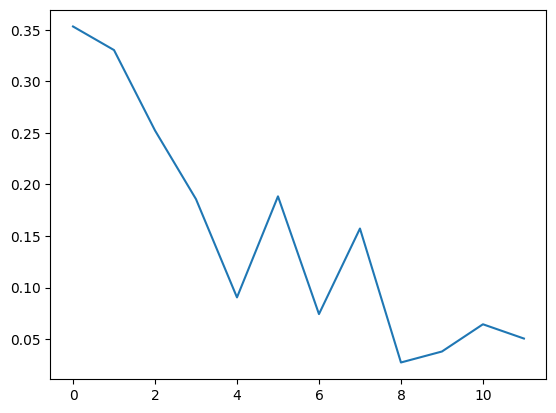

In [28]:
# Define the loss function and the optimizer
new_net1 = Encoder().to(device)
new_net2 = MLP().to(device)

loss_fun = nn.CrossEntropyLoss()
params = list(new_net1.parameters()) + list(new_net2.parameters())
optimizer = torch.optim.Adam(params, lr=1.e-3)

num_epochs = 2
loss_history = []
for epoch in range(num_epochs):
  for i ,(images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    latent = new_net1(images)
    output = new_net2(latent)
    loss = loss_fun(output, labels)
    loss.backward()
    optimizer.step()

    if (i+1) % batch_size == 0:
      loss_history.append(loss.item())
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))

plt.plot(loss_history)



In [29]:
# Run the trained model on the testing set
evaluate(new_net1, new_net2)

Percent correct: 97.860 %
